## Clustering Produktivitas *AI* *Developer* Berdasarkan Faktor Harian

### Masalah

Di lingkungan pengembangan perangkat lunak yang serba cepat, memaksimalkan hari kerja yang produktif adalah kunci keberhasilan proyek. Namun, keberhasilan harian seorang developer AI dipengaruhi oleh interaksi antar faktor seperti kebiasaan kerja, kesehatan, dan distraksi. Proses untuk mengidentifikasi pola kerja developer seringkali masih bersifat subjektif. Oleh karena itu, notebook ini berupaya untuk menghadirkan solusi pengelompokkan pola kerja harian secara objektif menggunakan teknik clustering.

### Tujuan

Mengelompokkan pola kerja harian developer AI

### Atribut Dataset

Dataset ini berisi 500 record developer AI dengan 9 atribut. Berikut penjelasan setiap atribut: 

- **hours_coding**: Total jam fokus yang dihabiskan untuk pekerjaan pengembangan perangkat lunak (rentang: 0–12 jam).

- **coffee_intake_mg**: Asupan kafein harian dalam miligram (rentang: 0–600 mg).

- **distractions**: Jumlah gangguan dalam sehari (contoh: rapat, notifikasi Slack) (rentang: 0–10).

- **sleep_hours**: Jumlah jam tidur pada malam sebelumnya (rentang: 3–10 jam).

- **commits**: Jumlah commit kode yang dilakukan selama sehari (rentang: 0–20).

- **bugs_reported**: Jumlah bug yang dilaporkan pada kode yang ditulis hari itu (rentang: 0–10).

- **ai_usage_hours**: Jumlah jam yang dihabiskan menggunakan alat bantu AI (contoh: ChatGPT, Copilot) (rentang: 0–12 jam).

- **cognitive_load**: Tingkat beban mental yang dilaporkan sendiri dalam skala 1 hingga 10.

- **task_success**: Kolom target — menunjukkan apakah target produktivitas harian tercapai (0 = Gagal, 1 = Berhasil).

## EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [2]:
df = pd.read_csv('../dataset/Productivity.csv')

In [3]:
df.head(5)

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1


In [4]:
df.duplicated().sum()

0

Tidak terdapat baris yang terduplikasi

In [5]:
df['task_success'].value_counts(normalize=True) * 100

task_success
1    60.6
0    39.4
Name: proportion, dtype: float64

In [6]:
df_target = df['task_success']
df = df.drop(columns='task_success')

Kolom task_success harus dibuang diawal untuk menemukan pola atau kelompok yang ada secara alami dalam data, tanpa terpengaruhi oleh label yang sudah diketahui. Jika kita menyertakan task_success, algoritma tidak akan menemukan pola tersembunyi, melainkan hanya akan mengelompokkan hari-hari menjadi dua kategori yang sudah jelas sejak awal yaitu hari "sukses" dan hari "gagal". Dengan memisahkan kolom ini, kita bisa secara independen mengidentifikasi faktor-faktor (seperti jam tidur, kafein, atau distraksi) yang berhubungan dengan keberhasilan, dan kemudian menggunakan task_success untuk memvalidasi klaster.

In [7]:
df.head(5)

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load
0,5.99,600,1,5.8,2,1,0.71,5.4
1,4.72,568,2,6.9,5,3,1.75,4.7
2,6.30,560,1,8.9,2,0,2.27,2.2
3,8.05,600,7,6.3,9,5,1.40,5.9
4,4.53,421,6,6.9,4,0,1.26,6.3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hours_coding      500 non-null    float64
 1   coffee_intake_mg  500 non-null    int64  
 2   distractions      500 non-null    int64  
 3   sleep_hours       500 non-null    float64
 4   commits           500 non-null    int64  
 5   bugs_reported     500 non-null    int64  
 6   ai_usage_hours    500 non-null    float64
 7   cognitive_load    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


Dataset terdiri dari 4 atribut bertipe float64 dan 4 atribut bertipe int64, serta tidak ditemukan adanya null 

#### Fitur Numerik

##### Distribusi

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hours_coding,500.0,5.01560,1.947253,0.0,3.6000,5.03,6.275,12.00
coffee_intake_mg,500.0,463.19200,142.334991,6.0,369.5000,500.50,600.000,600.00
distractions,500.0,2.97600,1.678409,0.0,2.0000,3.00,4.000,8.00
sleep_hours,500.0,6.97580,1.455965,3.0,6.1000,6.95,7.900,10.00
commits,500.0,4.60800,2.704990,0.0,3.0000,5.00,6.000,13.00
bugs_reported,500.0,0.85800,1.102846,0.0,0.0000,0.00,2.000,5.00
ai_usage_hours,500.0,1.51092,1.085557,0.0,0.6975,1.26,2.070,6.36
cognitive_load,500.0,4.49820,1.868861,1.0,3.1750,4.40,5.800,10.00



 PERSEBARAN FITUR NUMERIK


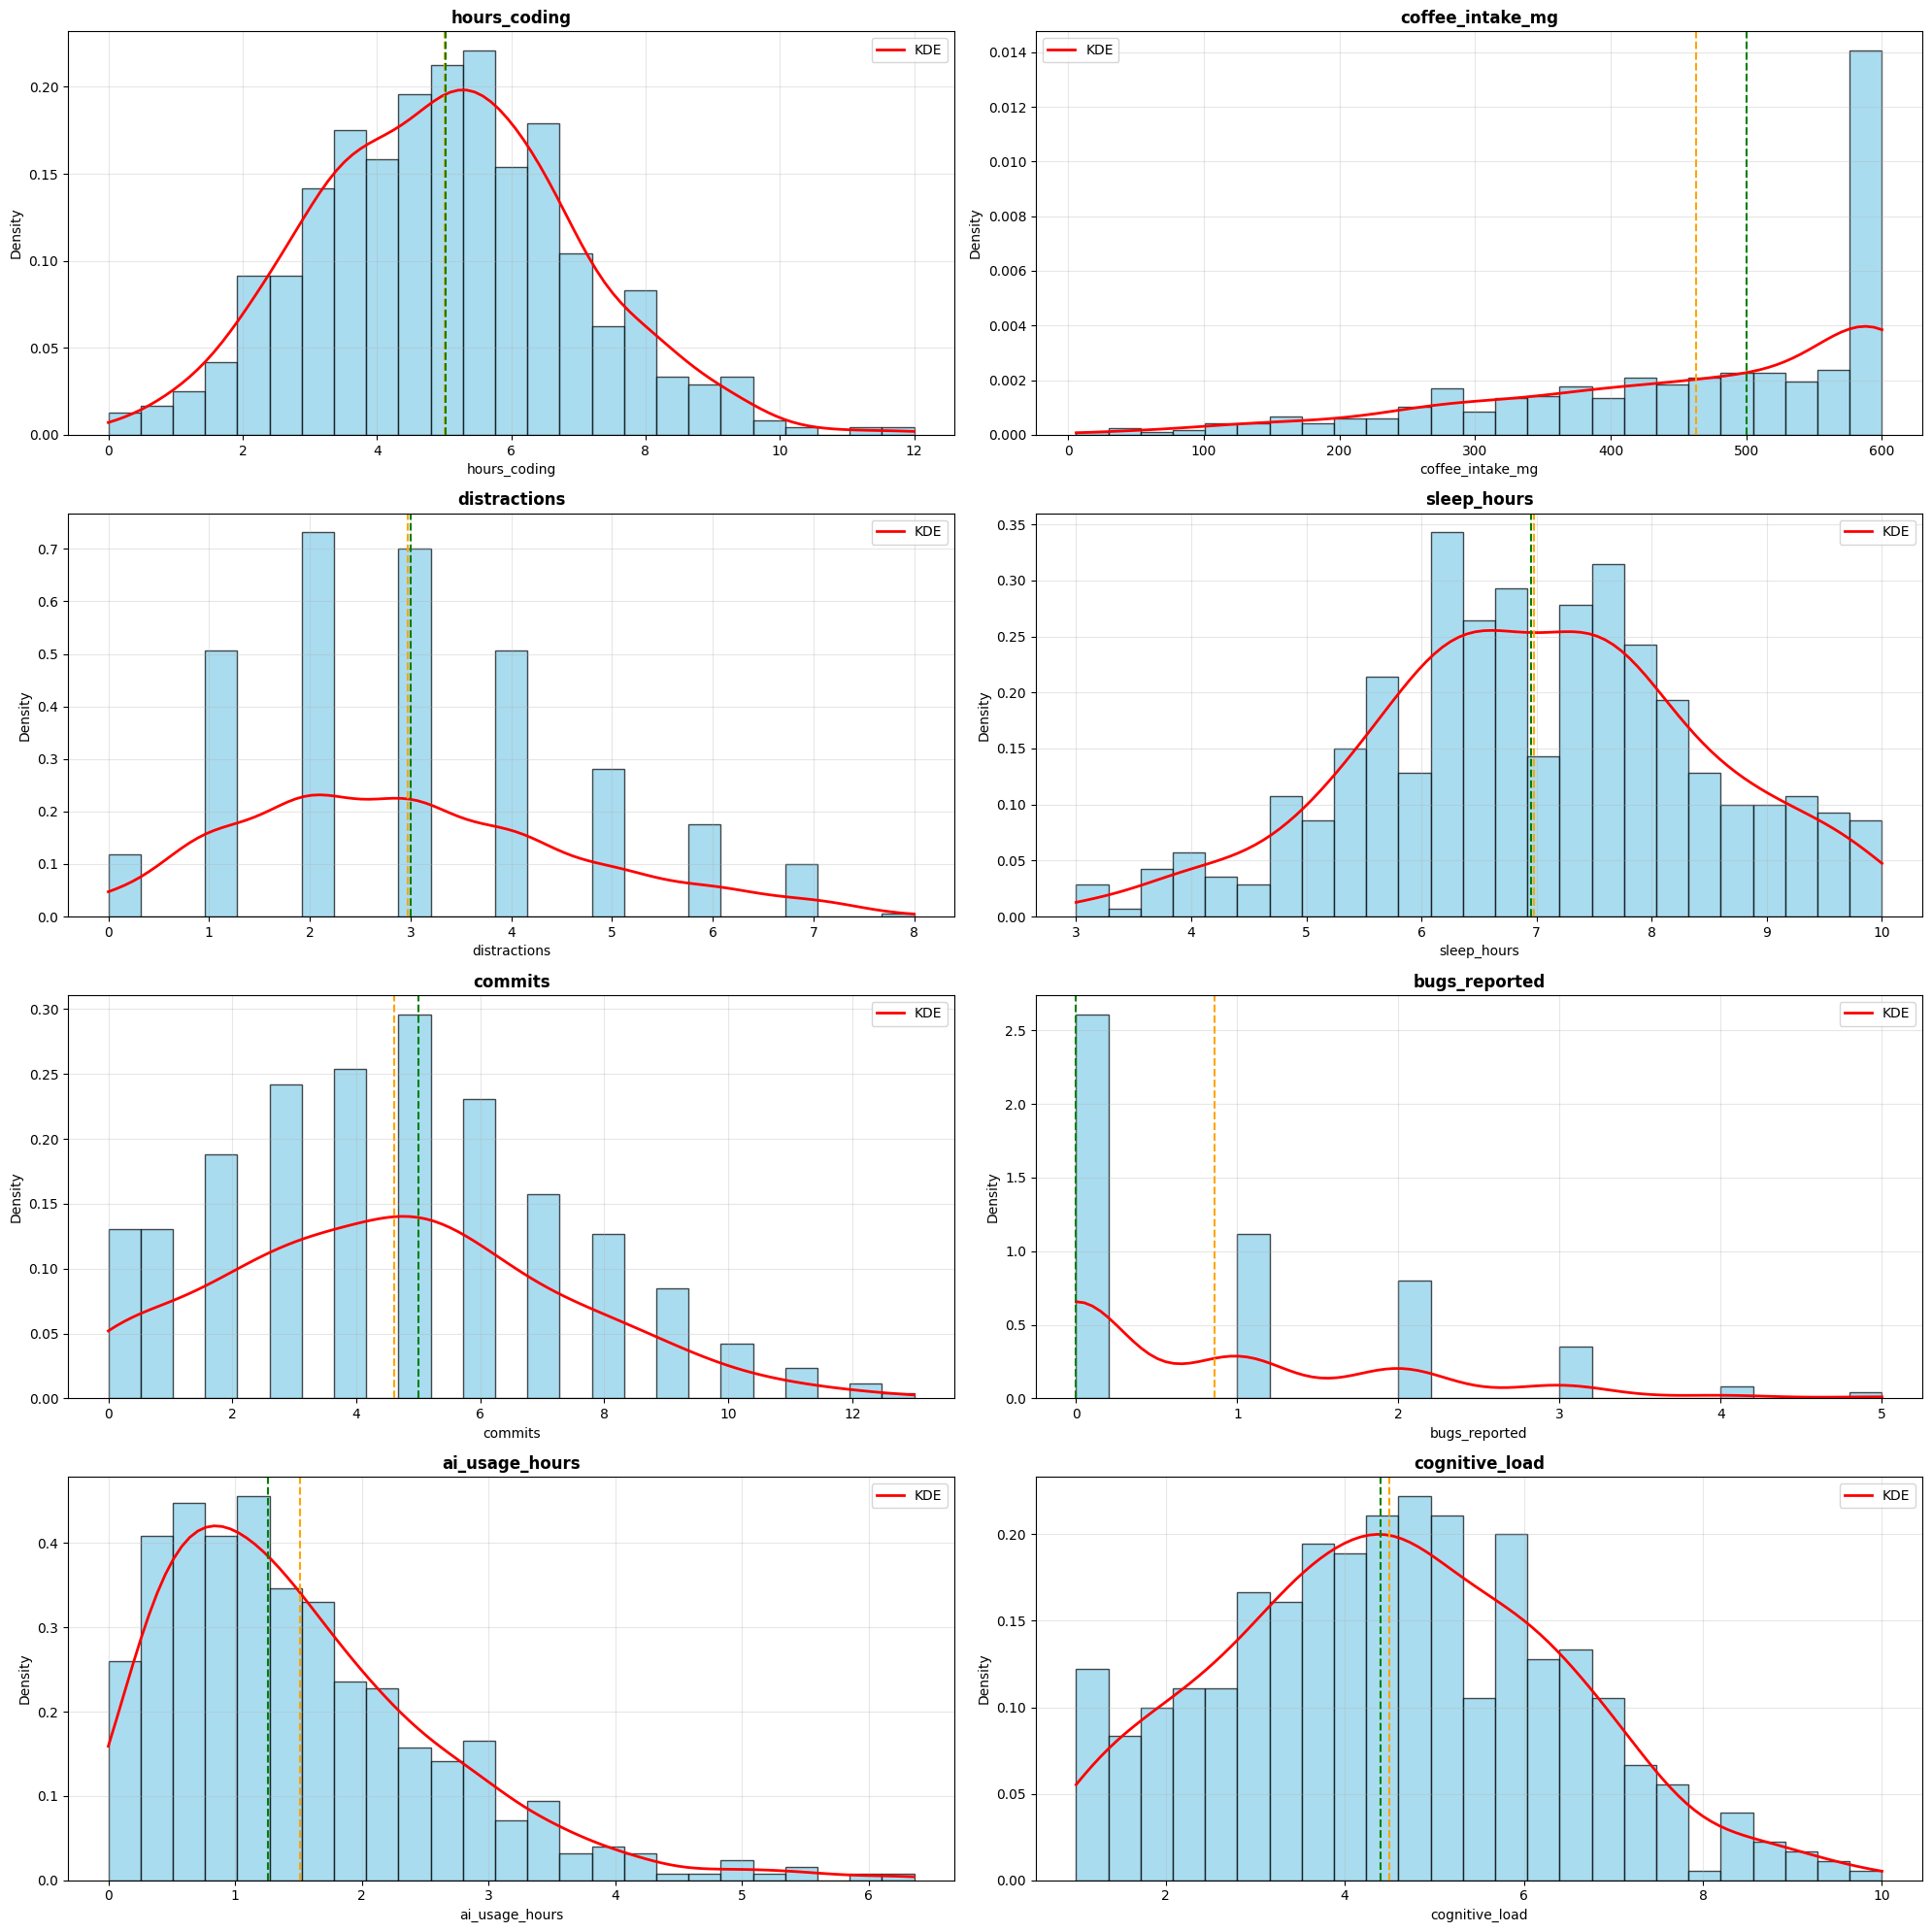

In [10]:
print("\n PERSEBARAN FITUR NUMERIK")
print("=" * 40)

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.ravel()

for i, feature in enumerate(df.columns):
    axes[i].hist(df[feature], bins=25, alpha=0.7, density=True, color='skyblue', edgecolor='black')

    x = np.linspace(df[feature].min(), df[feature].max(), 100)
    kde = stats.gaussian_kde(df[feature])
    axes[i].plot(x, kde(x), 'r-', linewidth=2, label='KDE')
    
    axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    
    # Stats
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    axes[i].axvline(mean_val, color='orange', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')

plt.tight_layout()
plt.show()

Berdasarkan grafik, hours_coding, sleep_hours, dan cognitive_load mengikuti distribusi normal, yang menunjukkan bahwa sebagian besar peserta memiliki durasi kerja, tidur, dan beban kognitif yang rata-rata. Sebaliknya, coffee_intake_mg, distractions, dan bugs_reported condong ke arah rendah, menunjukkan bahwa sebagian besar peserta mengonsumsi sedikit kopi, mengalami sedikit gangguan, dan melaporkan sedikit bug. Demikian pula, commits dan ai_usage_hours juga menunjukkan pola yang sama, menyiratkan bahwa sebagian besar peserta melakukan sedikit komit dan jarang menggunakan AI.

##### Outlier Detection


 BOXPLOT DETEKSI OUTLIER


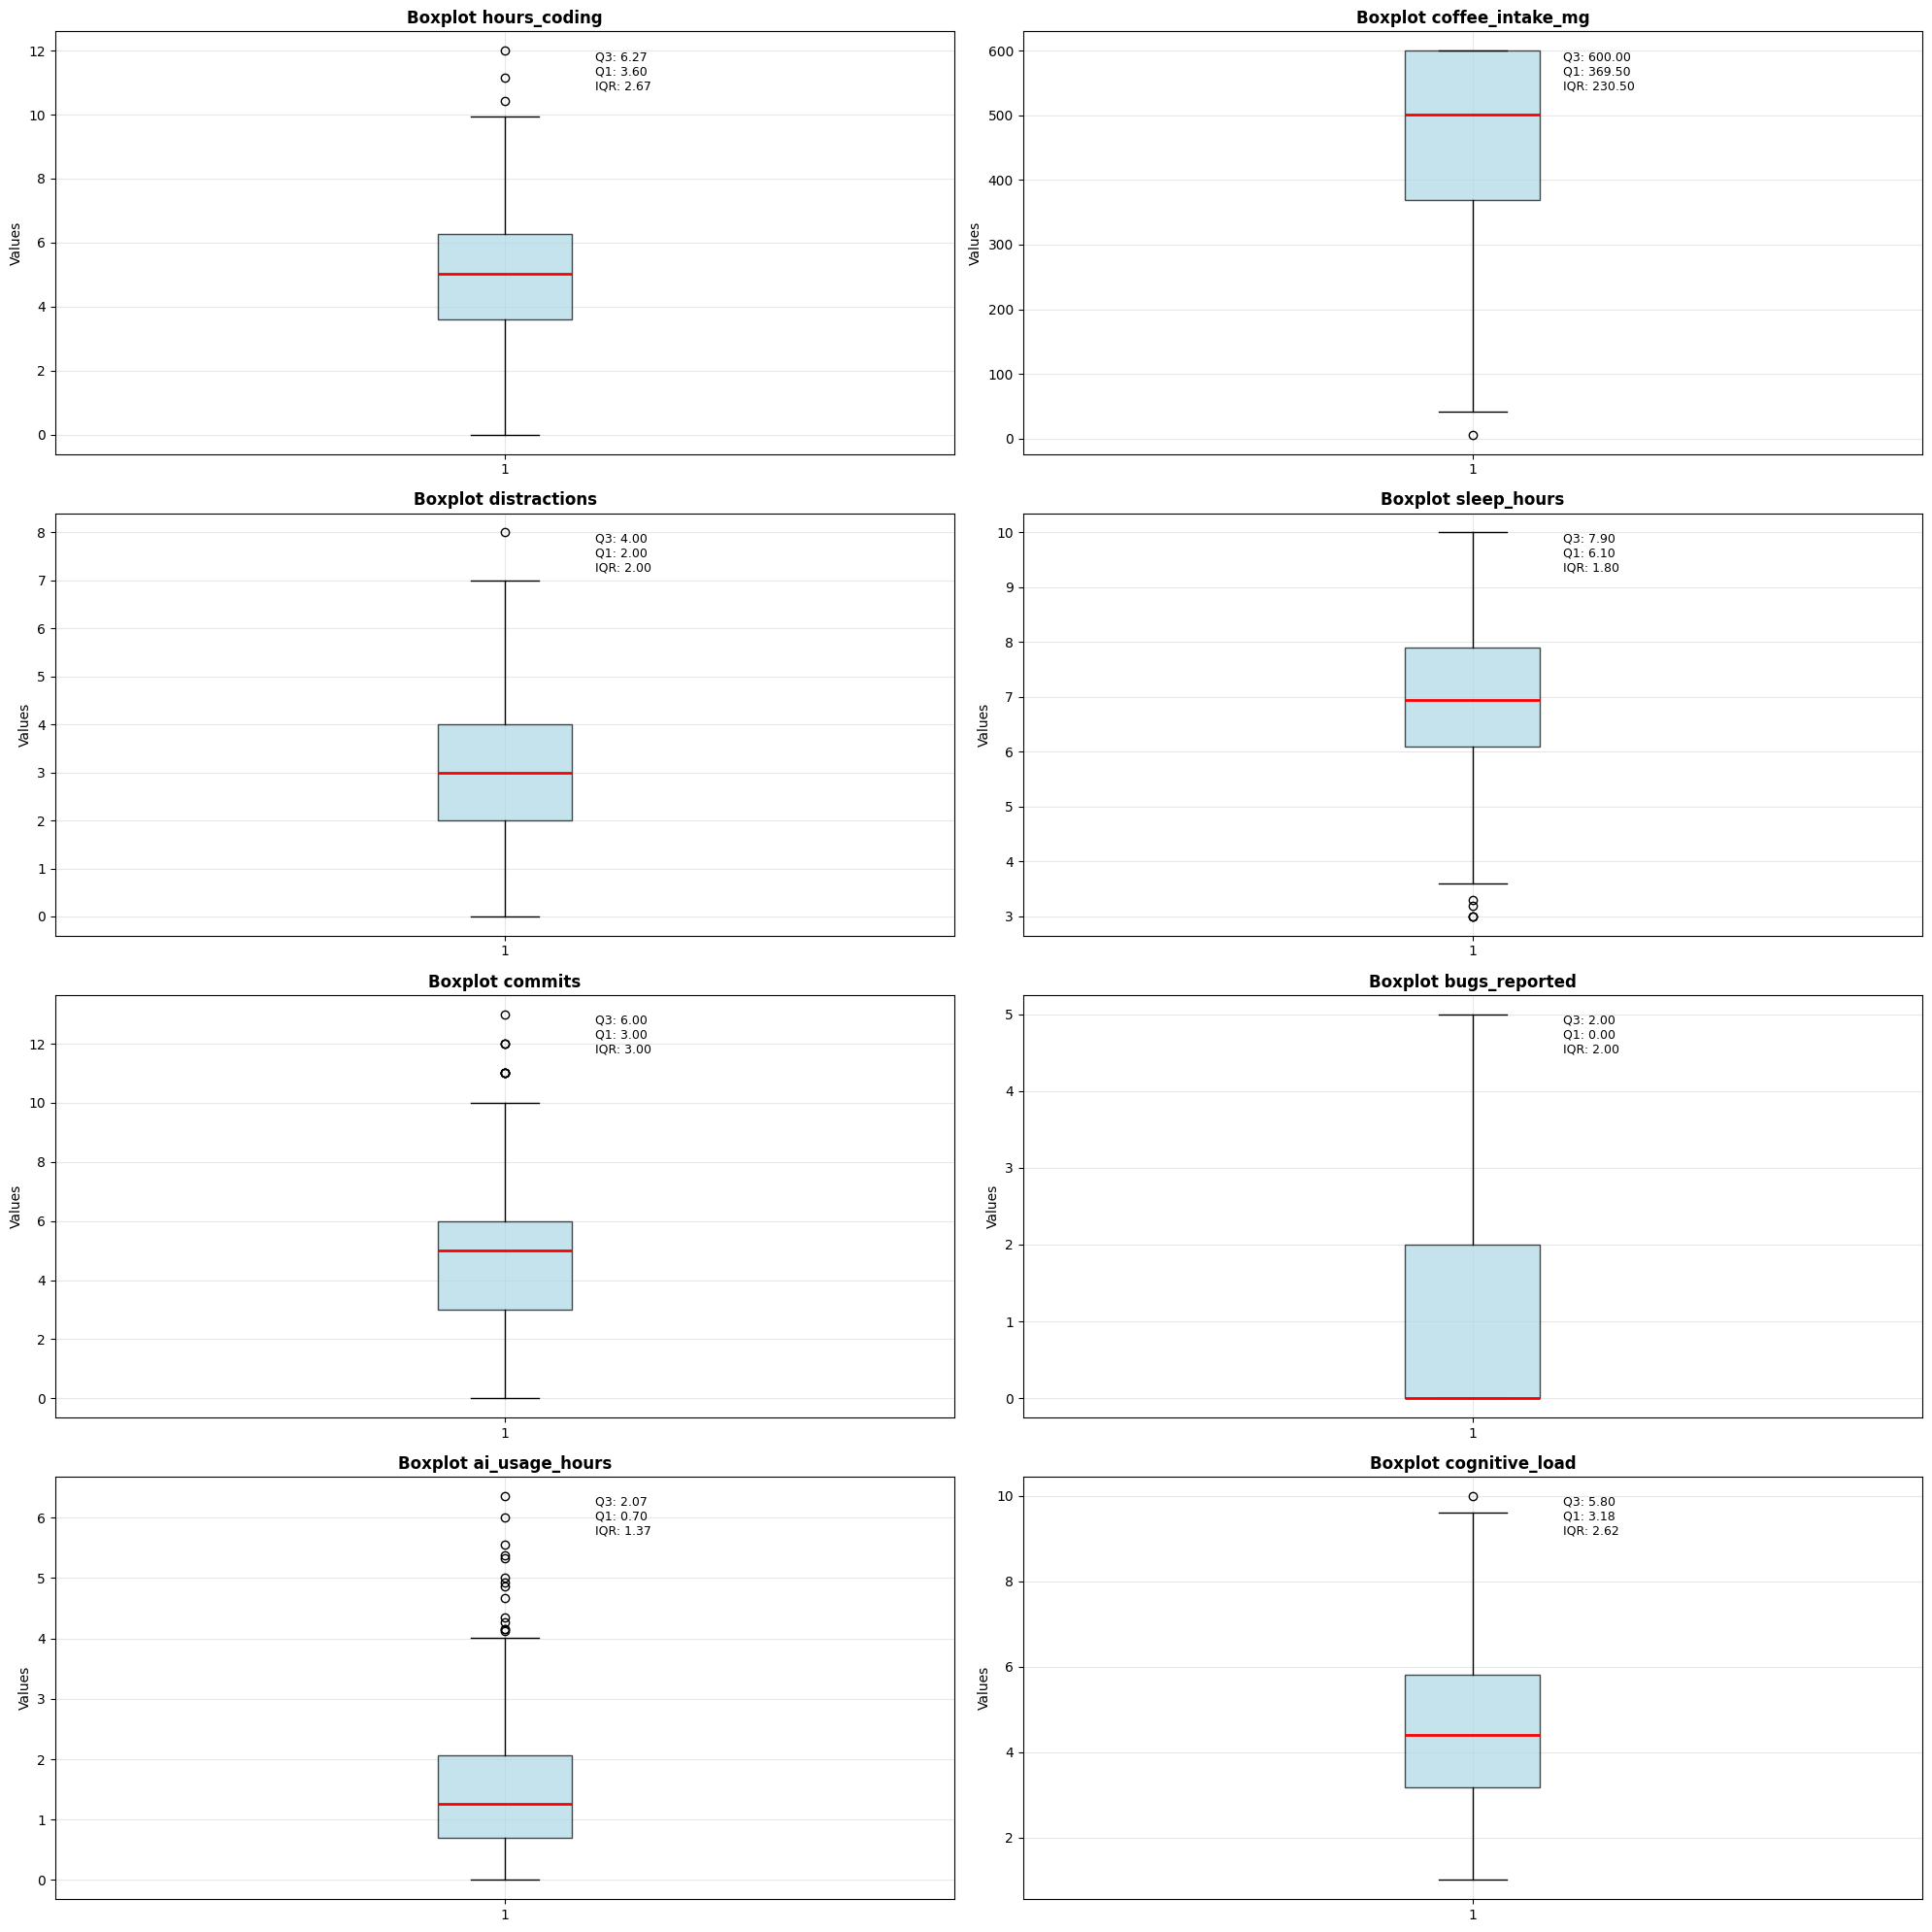

In [11]:
# Deteksi Outlier dengan boxplot
print("\n BOXPLOT DETEKSI OUTLIER")
print("=" * 40)

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.ravel()

for i, feature in enumerate(df.columns):
    # Boxplot
    box_plot = axes[i].boxplot(df[feature], patch_artist=True, 
                              boxprops=dict(facecolor='lightblue', alpha=0.7),
                              medianprops=dict(color='red', linewidth=2))
    
    axes[i].set_title(f'Boxplot {feature}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Values')
    axes[i].grid(True, alpha=0.3)
    
    # Tambahkan statistik pada plot
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    axes[i].text(1.1, df[feature].max(), f'Q3: {Q3:.2f}\nQ1: {Q1:.2f}\nIQR: {IQR:.2f}', 
                verticalalignment='top', fontsize=9)

plt.tight_layout()
plt.show()

In [12]:
# Deteksi outlier dengan IQR 
print("\n DETEKSI OUTLIER MENGGUNAKAN IQR")
print("=" * 50)


for feature in df.columns:
    print(f"\n {feature.upper()}")
    print("-" * 30)
    
    # Hitung quartile dan IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Hitung batas outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikasi outlier
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    
    print(f"Q1 (25th percentile): {Q1:.3f}")
    print(f"Q3 (75th percentile): {Q3:.3f}")
    print(f"IQR                 : {IQR:.3f}")
    print(f"Lower Bound         : {lower_bound:.3f}")
    print(f"Upper Bound         : {upper_bound:.3f}")
    print(f"Outlier Count       : {outlier_count}")
    print(f"Outlier Percentage  : {outlier_percentage:.2f}%")
    
    if outlier_count > 0:
        print(f"Outlier Range       : {outliers[feature].min():.3f} to {outliers[feature].max():.3f}")


 DETEKSI OUTLIER MENGGUNAKAN IQR

 HOURS_CODING
------------------------------
Q1 (25th percentile): 3.600
Q3 (75th percentile): 6.275
IQR                 : 2.675
Lower Bound         : -0.412
Upper Bound         : 10.287
Outlier Count       : 3
Outlier Percentage  : 0.60%
Outlier Range       : 10.440 to 12.000

 COFFEE_INTAKE_MG
------------------------------
Q1 (25th percentile): 369.500
Q3 (75th percentile): 600.000
IQR                 : 230.500
Lower Bound         : 23.750
Upper Bound         : 945.750
Outlier Count       : 1
Outlier Percentage  : 0.20%
Outlier Range       : 6.000 to 6.000

 DISTRACTIONS
------------------------------
Q1 (25th percentile): 2.000
Q3 (75th percentile): 4.000
IQR                 : 2.000
Lower Bound         : -1.000
Upper Bound         : 7.000
Outlier Count       : 1
Outlier Percentage  : 0.20%
Outlier Range       : 8.000 to 8.000

 SLEEP_HOURS
------------------------------
Q1 (25th percentile): 6.100
Q3 (75th percentile): 7.900
IQR                 : 

Berdasarkan analisis menggunakan metode IQR dan boxplot, hampir semua fitur menunjukkan adanya outlier kecuali pada fitur bugs_reported. Namun, jumlah outlier yang terdeteksi tidak signifikan, dengan persentase di bawah 3% dari total data pada setiap fitur.

##### Korelasi

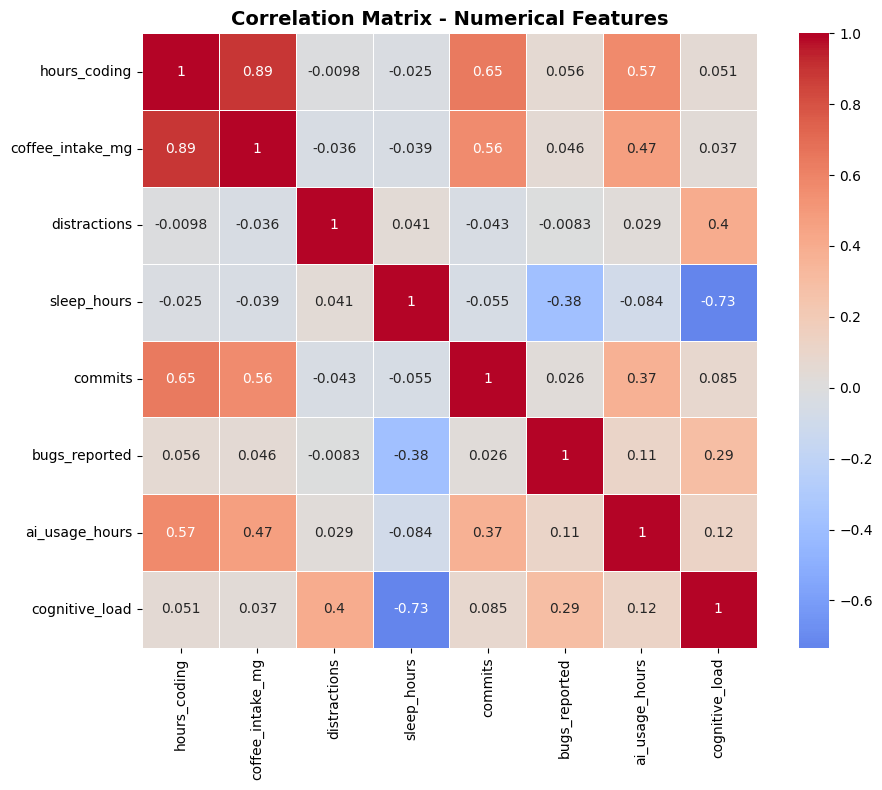

In [13]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[df.columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Berdasarkan matriks heatmap, terlihat beberapa fitur memiliki korelasi yang signifikan satu sama lain. Hubungan ini sebagian besar positif, seperti korelasi antara coffee_intake_mg dengan hours_coding, commits dengan hours_coding, coffee_intake_mg dengan commits, dan ai_usage_hours dengan hours_coding. Satu-satunya hubungan negatif yang signifikan adalah antara cognitive_load dan sleep_hours.

## Null Values

In [14]:
df.isnull().sum()

hours_coding        0
coffee_intake_mg    0
distractions        0
sleep_hours         0
commits             0
bugs_reported       0
ai_usage_hours      0
cognitive_load      0
dtype: int64

Tidak ada null values pada dataset ini.

## Data Transformation

In [15]:

def remove_outliers_iqr(df):
    df_clean = df.copy()
    
    for feature in df.columns:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[(df_clean[feature] >= lower_bound) & (df_clean[feature] <= upper_bound)]
    
    return df_clean

print(f"Data sebelum buang outlier: {df.shape}")
df = remove_outliers_iqr(df)
print(f"Data setelah buang outlier: {df.shape}")

Data sebelum buang outlier: (500, 8)
Data setelah buang outlier: (470, 8)


Metode IQR digunakan untuk menghapus outlier karena metode ini robust terhadap nilai ekstrem dan tidak terpengaruh oleh distribusi data yang tidak normal. IQR berfokus pada sebaran tengah data (kuartil 1 hingga 3), sehingga cocok untuk mendeteksi dataset yang skewed.

In [16]:
from sklearn.preprocessing import StandardScaler

df_scaled = df.copy()

scaler = StandardScaler()
df_scaled_values = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled_values, columns=df.columns, index=df.index)

print("Standardized")

Standardized


Standarisasi dilakukan karena algoritma clustering seperti K-Means dan DBSCAN karena bergantung pada perhitungan jarak untuk mengelompokkan data. Tanpa standarisasi, fitur dengan skala nilai yang lebih besar akan mendominasi perhitungan jarak dibandingkan fitur dengan skala kecil, sehingga menyebabkan pembentukan cluster yang bias dan tidak akurat. Standarisasi memastikan semua fitur memiliki skala yang seragam (mean=0, standar deviasi=1), sehingga setiap fitur berkontribusi secara seimbang dalam proses clustering.

In [17]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
hours_coding,470.0,1.341716e-16,1.001066,-2.752302,-0.731310,0.050781,0.692860,2.865179
coffee_intake_mg,470.0,-1.398409e-16,1.001066,-2.986421,-0.661853,0.248692,1.005695,1.005695
distractions,470.0,8.692810e-17,1.001066,-1.802214,-0.585202,0.023304,0.631811,2.457329
sleep_hours,470.0,-2.078715e-16,1.001066,-2.452378,-0.663710,-0.019790,0.624131,2.126612
commits,470.0,0.000000e+00,1.001066,-1.760792,-0.561991,-0.162391,0.636810,2.235210
bugs_reported,470.0,-6.047172e-17,1.001066,-0.778623,-0.778623,-0.778623,0.145500,3.841993
ai_usage_hours,470.0,1.285024e-16,1.001066,-1.556442,-0.788065,-0.192295,0.656816,2.875642
cognitive_load,470.0,4.044046e-16,1.001066,-1.902794,-0.737312,-0.015823,0.705666,2.870132


## PCA

In [18]:
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(df_scaled)

explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio) 

# Mengambil fitur untuk 80% variance
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1
pca_optimal = PCA(n_components=n_components_80)
df_pca = pca_optimal.fit_transform(df_scaled)

print("PCA done")

PCA done



PRINCIPAL COMPONENT ANALYSIS (PCA)


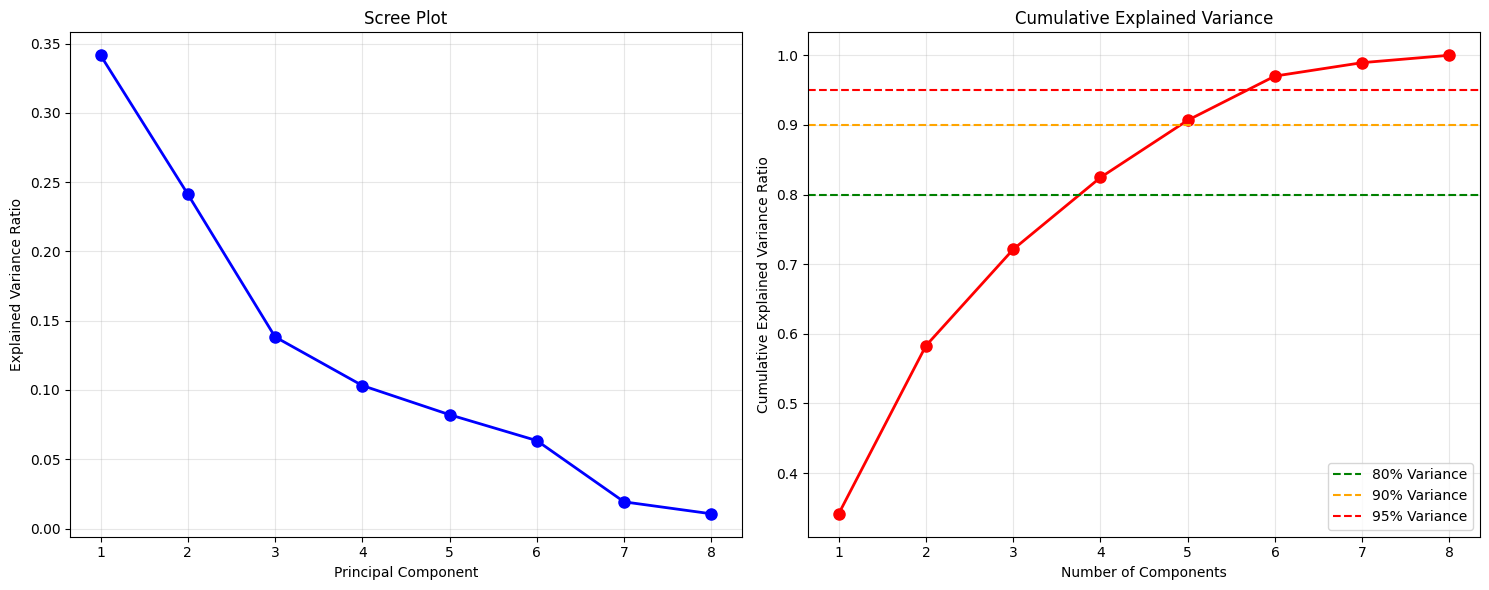

In [19]:
print("\nPRINCIPAL COMPONENT ANALYSIS (PCA)")
print("=" * 50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scree Plot
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(explained_variance_ratio) + 1))

# Cumulative Explained Variance Plot
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.8, color='g', linestyle='--', label='80% Variance')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% Variance')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, len(cumulative_variance_ratio) + 1))

plt.tight_layout()
plt.show()

In [20]:
# myPCA
from unsupervised_learning.PCA import myPCA

myPCA_instance = myPCA(n_components= 4)
myPCA_instance.fit(df_scaled)

explained_variance_ratio = myPCA_instance.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

myPCA_data = myPCA_instance.fit_transform(df_scaled)


 myPCA 


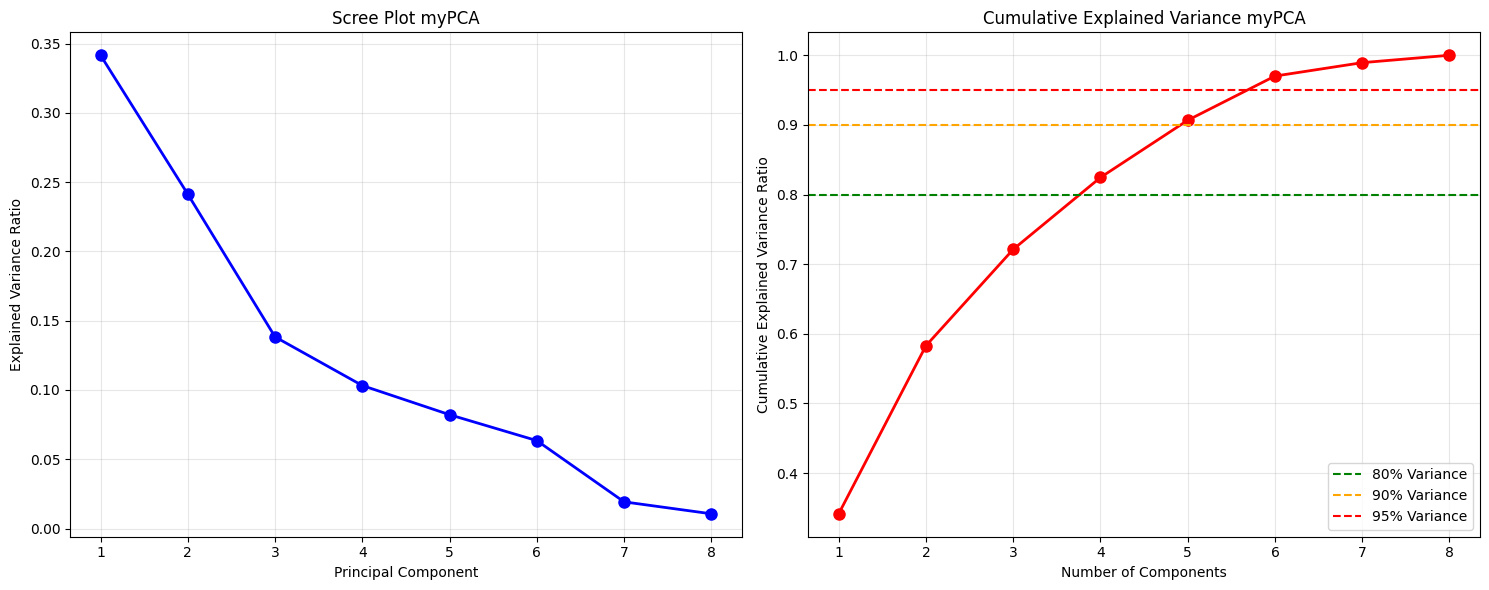

In [21]:
print("\n myPCA ")
print("=" * 50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scree Plot
ax1.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot myPCA')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, len(explained_variance_ratio) + 1))

# Cumulative Explained Variance Plot
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.8, color='g', linestyle='--', label='80% Variance')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% Variance')
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Explained Variance myPCA')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, len(cumulative_variance_ratio) + 1))

plt.tight_layout()
plt.show()

## DBSCAN

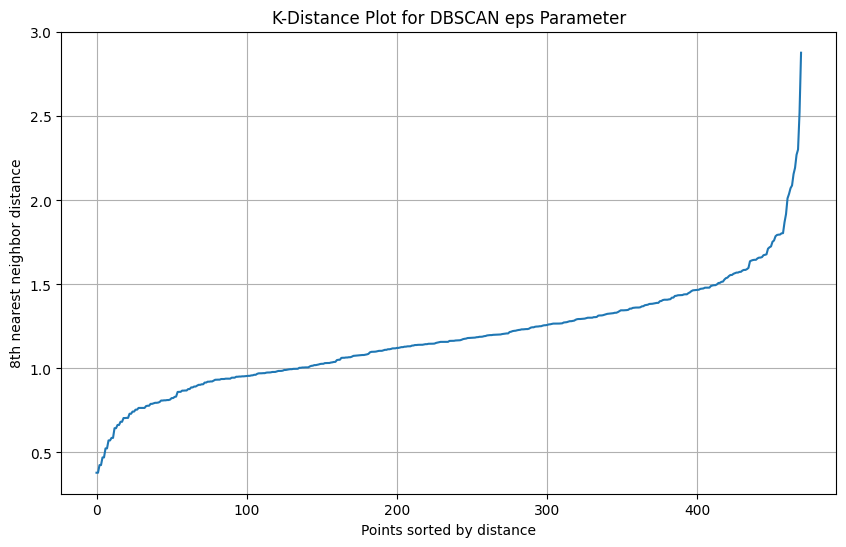

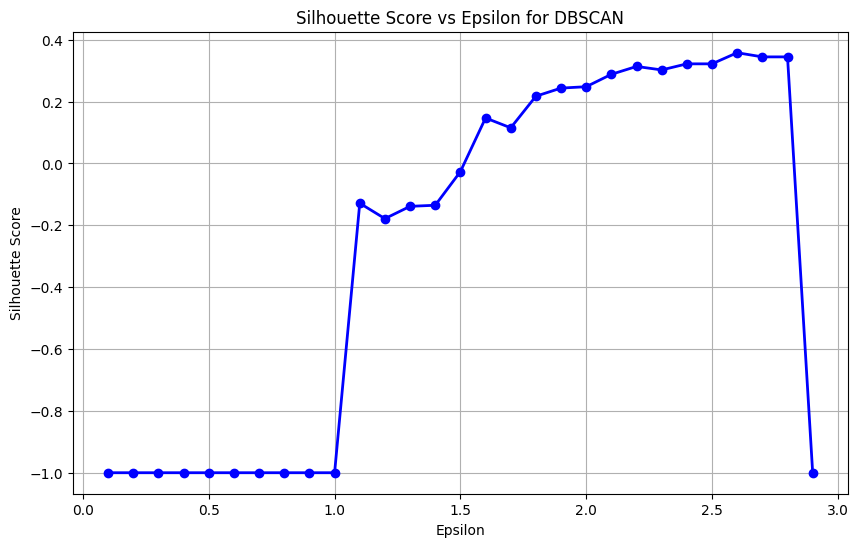

Optimal epsilon: 2.6
Best silhouette score: 0.3578


In [22]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.cluster import DBSCAN

k = 8
nbrs = NearestNeighbors(n_neighbors=k).fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-Distance Plot for DBSCAN eps Parameter')
plt.xlabel('Points sorted by distance')
plt.ylabel('8th nearest neighbor distance')
plt.grid(True)
plt.show()

eps_values = np.arange(0.1, 3.0, 0.1)
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=8)
    labels = dbscan.fit_predict(df_scaled)
    if len(set(labels)) > 1:  # Minimal 2 cluster
        score = silhouette_score(df_scaled, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)

plt.figure(figsize=(10, 6))
plt.plot(eps_values, silhouette_scores, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Epsilon for DBSCAN')
plt.grid(True)
plt.show()

best_eps = eps_values[np.argmax(silhouette_scores)]
print(f"Optimal epsilon: {best_eps:.1f}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")

Nilai epsilon 2.6 dipilih karena menunjukan Silhouette Score paling tinggi.
Silhouette Score sendiri lebih dipilih dibanding Elbow Method karena memberikan penilaian kualitas clustering yang lebih objektif. Elbow Method mengandalkan visualisasi dalam menentukan jumlah cluster optimal, yang rentan terhadap subjektivitas, terutama ketika "siku" pada grafik tidak jelas. Sementara Silhouette Score mengukur seberapa baik setiap titik data berada dalam clusternya sendiri dibandingkan dengan cluster lain, sehingga menghasilkan evaluasi yang lebih baik.

In [23]:
#DBSCAN SKLEARN

db = DBSCAN(eps=2.6, min_samples=8)
db.fit(df_scaled)
sPredDB = pd.Series(db.labels_)
print(pd.concat({'count': sPredDB.value_counts(),
                 'percent': round(sPredDB.value_counts(normalize=True)*100, 2)}, 
                axis=1))

    count  percent
 0    468    99.57
-1      2     0.43


In [24]:
#Analisis karakteristik cluster
df_original = df.copy()

df_original['kmeans_cluster'] = sPredDB

print("\nKarakteristik rata-rata per cluster:")
print("=" * 50)
cluster_chars_DB = df_original.groupby('kmeans_cluster').agg({
    'ai_usage_hours': 'mean',
    'distractions': 'mean',
    'sleep_hours': 'mean',
    'bugs_reported': 'mean',
    'coffee_intake_mg': 'mean',
    'hours_coding': 'mean',
    'commits': 'mean',
    'cognitive_load': 'mean'

}).round(3)

cluster_chars_DB


Karakteristik rata-rata per cluster:


,ai_usage_hours,distractions,sleep_hours,bugs_reported,coffee_intake_mg,hours_coding,commits,cognitive_load
kmeans_cluster,,,,,,,,
-1.0,0.815,6.000,7.550,2.500,383.000,4.920,4.50,5.35
0.0,1.396,2.959,7.013,0.832,460.884,4.871,4.42,4.41


In [25]:
# Evaluasi Silhouette Score dari hasil DBSCAN SKLEARN
silhouette_avg = silhouette_score(df_scaled, sPredDB)
print(f"\nSilhouette Score untuk DBSCAN (eps={best_eps:.1f}): {silhouette_avg:.4f}")

silhouette_sample_scores = silhouette_samples(df_scaled, sPredDB)

# Analisis per cluster
print("\nSilhouette Score per cluster:")
for i in range(2):
    cluster_silhouette_scores = silhouette_sample_scores[sPredDB == i]
    print(f"Cluster {i}: {cluster_silhouette_scores.mean():.4f} (±{cluster_silhouette_scores.std():.4f})")


Silhouette Score untuk DBSCAN (eps=2.6): 0.3578

Silhouette Score per cluster:
Cluster 0: 0.3584 (±0.1584)
Cluster 1: nan (±nan)


C:\Users\Owen\AppData\Local\Temp\ipykernel_13808\57161897.py:11: RuntimeWarning: Mean of empty slice.
  print(f"Cluster {i}: {cluster_silhouette_scores.mean():.4f} (±{cluster_silhouette_scores.std():.4f})")
c:\Users\Owen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Owen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Owen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Owen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type

In [26]:
# myDBSCAN
from unsupervised_learning.DBSCAN import myDBSCAN

myDBSCAN_instance = myDBSCAN(eps=2.6, min_samples=8)
myDBSCAN_instance.fit(df_scaled.to_numpy())

sPredDB = pd.Series(myDBSCAN_instance.labels_)
print(pd.concat({'count': sPredDB.value_counts(),
                 'percent': round(sPredDB.value_counts(normalize=True)*100, 2)}, 
                axis=1))

    count  percent
 1    468    99.57
-1      2     0.43


In [27]:
#Analisis karakteristik cluster myDBSCAN
df_original = df.copy()

df_original['kmeans_cluster'] = sPredDB

print("\nKarakteristik rata-rata per cluster:")
print("=" * 50)
cluster_chars_DB = df_original.groupby('kmeans_cluster').agg({
    'ai_usage_hours': 'mean',
    'distractions': 'mean',
    'sleep_hours': 'mean',
    'bugs_reported': 'mean',
    'coffee_intake_mg': 'mean',
    'hours_coding': 'mean',
    'commits': 'mean',
    'cognitive_load': 'mean'

}).round(3)

cluster_chars_DB


Karakteristik rata-rata per cluster:


,ai_usage_hours,distractions,sleep_hours,bugs_reported,coffee_intake_mg,hours_coding,commits,cognitive_load
kmeans_cluster,,,,,,,,
-1.0,0.815,6.000,7.550,2.500,383.000,4.920,4.50,5.35
1.0,1.396,2.959,7.013,0.832,460.884,4.871,4.42,4.41


In [28]:
# Evaluasi Silhouette Score dari hasil myDBSCAN
silhouette_avg = silhouette_score(df_scaled, sPredDB)
print(f"\nSilhouette Score untuk myDBSCAN (eps={best_eps:.1f}): {silhouette_avg:.4f}")

silhouette_sample_scores = silhouette_samples(df_scaled, sPredDB)

# Analisis per cluster
print("\nSilhouette Score per cluster:")
for i in range(2):
    cluster_silhouette_scores = silhouette_sample_scores[sPredDB == i]
    print(f"Cluster {i}: {cluster_silhouette_scores.mean():.4f} (±{cluster_silhouette_scores.std():.4f})")


Silhouette Score untuk myDBSCAN (eps=2.6): 0.3578

Silhouette Score per cluster:
Cluster 0: nan (±nan)
Cluster 1: 0.3584 (±0.1584)


C:\Users\Owen\AppData\Local\Temp\ipykernel_13808\299177134.py:11: RuntimeWarning: Mean of empty slice.
  print(f"Cluster {i}: {cluster_silhouette_scores.mean():.4f} (±{cluster_silhouette_scores.std():.4f})")
c:\Users\Owen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Owen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Owen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Owen\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.typ

DBSCAN, baik yang diimplementasikan menggunakan sklearn maupun dari scratch dengan nilai epsilon 2.6, hanya menghasilkan satu cluster pada dataset ini. Hal ini terjadi karena sebagian besar data tidak memenuhi kriteria kepadatan yang ditentukan dan diklasifikasikan sebagai noise, sehingga tidak terbentuk cluster tambahan.

## K-Means

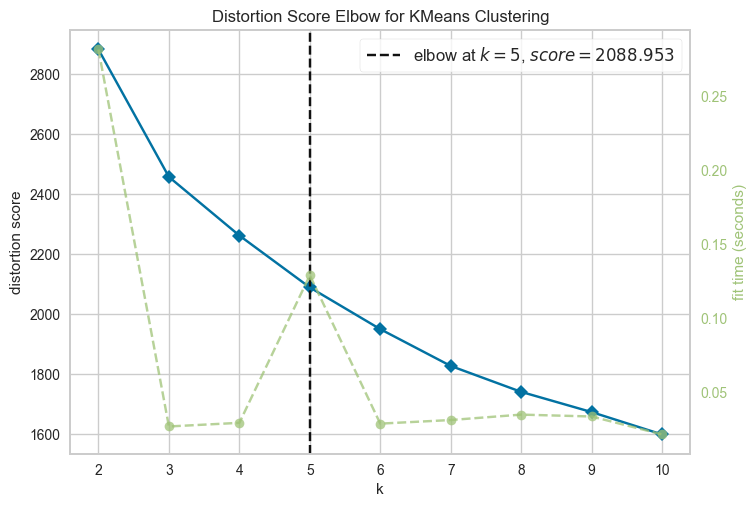

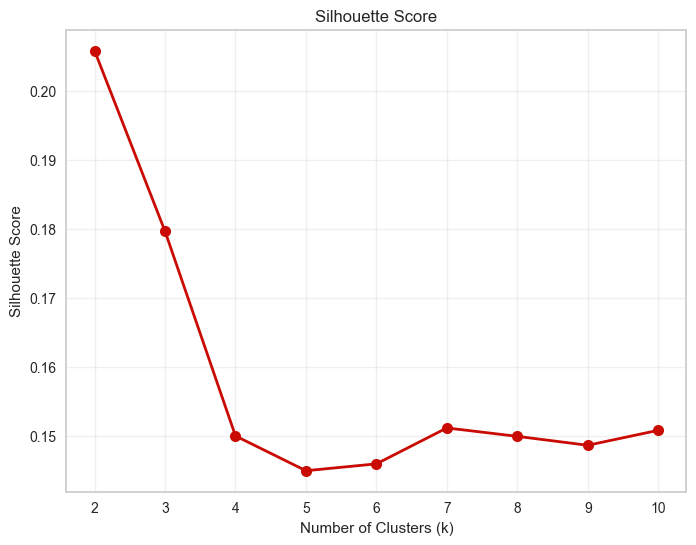

Optimal k berdasarkan silhouette score: 2
Silhouette Score: 0.2058


In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
from warnings import filterwarnings

filterwarnings("ignore")

# Elbow Method 
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,11), metric='distortion')
visualizer.fit(df_scaled)
visualizer.show()

# Silhouette Score
silhouette_scores = []
k_range = np.arange(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True, alpha=0.3)
plt.show()

# Hasil terbaik
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal k berdasarkan silhouette score: {best_k}")
print(f"Silhouette Score: {max(silhouette_scores):.4f}")

Nilai cluster K=2 dipilih karena menunjukan silhouette score paling tinggi.
Silhouette Score sendiri lebih dipilih dibanding Elbow Method karena memberikan penilaian kualitas clustering yang lebih objektif. Elbow Method mengandalkan visualisasi dalam menentukan jumlah cluster optimal, yang rentan terhadap subjektivitas, terutama ketika "siku" pada grafik tidak jelas. Sementara Silhouette Score mengukur seberapa baik setiap titik data berada dalam clusternya sendiri dibandingkan dengan cluster lain, sehingga menghasilkan evaluasi yang lebih baik.

In [30]:
# K-Means SKLEARN
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_final.fit(df_scaled)
sPredKM = pd.Series(kmeans_final.labels_)
pd.concat({'count': sPredKM.value_counts(),
                 'percent': round(sPredKM.value_counts(normalize=True)*100, 2)}, 
                axis=1)

,count,percent
0,271,57.66
1,199,42.34


In [31]:
#Analisis karakteristik cluster
df_original = df.copy()

df_original['kmeans_cluster'] = sPredKM
df_original['task_success'] = df_target.loc[df_original.index]

print("\nKarakteristik rata-rata per cluster:")
print("=" * 50)
cluster_chars_KM = df_original.groupby('kmeans_cluster').agg({
    'ai_usage_hours': 'mean',
    'distractions': 'mean',
    'sleep_hours': 'mean',
    'bugs_reported': 'mean',
    'coffee_intake_mg': 'mean',
    'hours_coding': 'mean',
    'commits': 'mean',
    'cognitive_load': 'mean',
    'task_success': 'mean'

}).round(3)

cluster_chars_KM


Karakteristik rata-rata per cluster:


,ai_usage_hours,distractions,sleep_hours,bugs_reported,coffee_intake_mg,hours_coding,commits,cognitive_load,task_success
kmeans_cluster,,,,,,,,,
0.0,1.376,3.000,7.038,0.827,466.753,4.929,4.443,4.372,0.624
1.0,1.417,2.936,6.986,0.856,452.096,4.792,4.388,4.471,0.590


In [32]:
# Evaluasi Silhouette Score dari hasil K-Means SKLEARN
silhouette_avg = silhouette_score(df_scaled, sPredKM)
print(f"\nSilhouette Score untuk K-Means (k=2): {silhouette_avg:.4f}")

silhouette_sample_scores = silhouette_samples(df_scaled, sPredKM)

# Analisis per cluster
print("\nSilhouette Score per cluster:")
for i in range(2):
    cluster_silhouette_scores = silhouette_sample_scores[sPredKM == i]
    print(f"Cluster {i}: {cluster_silhouette_scores.mean():.4f} (±{cluster_silhouette_scores.std():.4f})")


Silhouette Score untuk K-Means (k=2): 0.2058

Silhouette Score per cluster:
Cluster 0: 0.1821 (±0.1062)
Cluster 1: 0.2381 (±0.1033)


In [33]:
# myKMEANS
from unsupervised_learning.Kmeans import myKmeans
myKmeans_instance = myKmeans(n_clusters=2)
myKmeans_instance.fit(df_scaled.to_numpy())

sPredKM = pd.Series(myKmeans_instance.labels_)
pd.concat({'count': sPredKM.value_counts(),
                'percent': round(sPredKM.value_counts(normalize=True)*100, 2)}, 
                axis=1)

,count,percent
1,271,57.66
0,199,42.34


In [34]:
#Analisis karakteristik cluster myKmeans
df_original = df.copy()

df_original['kmeans_cluster'] = sPredKM
df_original['task_success'] = df_target.loc[df_original.index]

print("\nKarakteristik rata-rata per cluster myKmeans:")
print("=" * 50)
cluster_chars_KM = df_original.groupby('kmeans_cluster').agg({
    'ai_usage_hours': 'mean',
    'distractions': 'mean',
    'sleep_hours': 'mean',
    'bugs_reported': 'mean',
    'coffee_intake_mg': 'mean',
    'hours_coding': 'mean',
    'commits': 'mean',
    'cognitive_load': 'mean',
    'task_success': 'mean'

}).round(3)

cluster_chars_KM


Karakteristik rata-rata per cluster myKmeans:


,ai_usage_hours,distractions,sleep_hours,bugs_reported,coffee_intake_mg,hours_coding,commits,cognitive_load,task_success
kmeans_cluster,,,,,,,,,
0.0,1.417,2.936,6.986,0.856,452.096,4.792,4.388,4.471,0.590
1.0,1.376,3.000,7.038,0.827,466.753,4.929,4.443,4.372,0.624


Berdasarkan hasil clustering dengan K-Means, data dapat dibagi menjadi dua kelompok. Kelompok pertama (Cluster 1.0) cenderung menunjukkan pola kerja yang lebih produktif, dengan rata-rata jam coding, commits, dan konsumsi kafein yang lebih tinggi. Hal ini berkorelasi dengan tingkat task success yang juga lebih tinggi. Sementara itu, kelompok kedua (Cluster 0.0) menunjukkan adanya tantangan, dengan rata-rata bugs yang dilaporkan, beban kognitif, dan penggunaan AI yang sedikit lebih tinggi. Oleh karena itu, tingkat task success mereka cenderung lebih rendah.

In [35]:
# Evaluasi Silhouette Score dari hasil myKmeans
silhouette_avg = silhouette_score(df_scaled, sPredKM)
print(f"\nSilhouette Score untuk myKmeans (k=2): {silhouette_avg:.4f}")

silhouette_sample_scores = silhouette_samples(df_scaled, sPredKM)

# Analisis per cluster
print("\nSilhouette Score per cluster:")
for i in range(2):
    cluster_silhouette_scores = silhouette_sample_scores[sPredKM == i]
    print(f"Cluster {i}: {cluster_silhouette_scores.mean():.4f} (±{cluster_silhouette_scores.std():.4f})")


Silhouette Score untuk myKmeans (k=2): 0.2058

Silhouette Score per cluster:
Cluster 0: 0.2381 (±0.1033)
Cluster 1: 0.1821 (±0.1062)
